In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client()

# Replace with your project ID and BigQuery table details
project_id = "airy-box-431604-j9"
dataset_id = "amazon_reviews"
table_id = "clean_data"

# Construct the full table ID
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Query the table
query = f"SELECT * FROM `{table_ref}`"

# Execute the query and convert it to a pandas DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Display the DataFrame
df.head()

,rating,review_hash,review_text,title,helpful_votes
0,1,[c5d09009a6af8d2e2e9f1277cc2de995],"Quality is so bad , mic is not working from fi...",Fraud,0
1,1,[103c65ebc6befe17501963a5f397f774],The media could not be loaded.\n ...,Right bud is not working,0
2,1,[1247140d70ccef9f31a2e898867bccb4],"Don't buy this Crossbeats, I brought Crossbeat...",Worst and fake Product,0
3,1,[5d5ff017a6a051fe6c231bf92717343d],sound is decent but battery dies pretty quick ...,NOT GOOD AT ALL,0
4,1,[2e19530b6a218397ce4ae9793ff788c4],Volume has not good compare to other brands,Volume issue,0


In [3]:
df['helpful_votes'] = df['helpful_votes'].astype(int)

In [4]:
df.columns

Index(['rating', 'review_hash', 'review_text', 'title', 'helpful_votes'], dtype='object')

In [5]:
df.drop(columns='review_hash', inplace=True)

In [6]:
# Feature 1: Review Length
df['review_length'] = df['review_text'].apply(len)
df['review_word_count'] = df['review_text'].apply(lambda x: len(word_tokenize(x)))

In [7]:
# Feature 2: Sentiment Score
df['review_sentiment'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['review_subjectivity'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [8]:
# Feature 3: Readability Score (Flesch-Kincaid Score)
def flesch_kincaid(text):
    words = word_tokenize(text)
    sentences = len(re.split(r'[.!?]', text))
    syllables = sum([len([s for s in word if s in 'aeiou']) for word in words])
    if len(words) == 0 or sentences == 0:
        return np.nan
    return 206.835 - (1.015 * (len(words) / sentences)) - (84.6 * (syllables / len(words)))

df['flesch_kincaid'] = df['review_text'].apply(flesch_kincaid)

In [9]:
# Feature 4: TF-IDF Vectors
vectorizer = TfidfVectorizer(max_features=100)  # Use max_features to limit dimensions
tfidf_matrix = vectorizer.fit_transform(df['review_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df = pd.concat([df, tfidf_df], axis=1)

In [10]:
# Feature 5: Presence of Specific Keywords
keywords = ['good', 'bad', 'recommend', 'disappoint', 'excellent']
for keyword in keywords:
    df[f'keyword_{keyword}'] = df['review_text'].apply(lambda x: int(keyword in x.lower()))

In [11]:
# Feature 6: Rating Deviation (assuming you have an average rating for the product)
# Suppose `avg_rating` is the average rating for the product
avg_rating = df['rating'].mean()
df['rating_deviation'] = df['rating'] - avg_rating

In [12]:
# Feature 7: Title Sentiment
df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['title_length'] = df['title'].apply(len)

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
# Feature 8: Parts of Speech (POS) Tags
def pos_counts(text):
    words = word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    pos_counts = {"nouns": 0, "verbs": 0, "adjectives": 0}
    for _, tag in pos_tags:
        if tag.startswith('N'):
            pos_counts["nouns"] += 1
        elif tag.startswith('V'):
            pos_counts["verbs"] += 1
        elif tag.startswith('J'):
            pos_counts["adjectives"] += 1
    return pd.Series(pos_counts)

df[['nouns_count', 'verbs_count', 'adjectives_count']] = df['review_text'].apply(pos_counts)

In [15]:
# Feature 9: Negations Count
negations = ["not", "no", "never", "none"]
df['negation_count'] = df['review_text'].apply(lambda x: sum([x.lower().count(neg) for neg in negations]))

In [16]:
# Feature 10: Pronouns Count
pronouns = ["i", "we", "you", "he", "she", "they"]
df['pronoun_count'] = df['review_text'].apply(lambda x: sum([x.lower().count(pronoun) for pronoun in pronouns]))

In [17]:
# Feature 11: Helpful Votes to Review Length Ratio
df['helpful_to_length_ratio'] = df['helpful_votes'] / (df['review_length'] + 1)  # Adding 1 to avoid division by zero

In [18]:
# Review the extracted features
df.head()

,rating,review_text,title,helpful_votes,review_length,review_word_count,review_sentiment,review_subjectivity,flesch_kincaid,after,...,keyword_excellent,rating_deviation,title_sentiment,title_length,nouns_count,verbs_count,adjectives_count,negation_count,pronoun_count,helpful_to_length_ratio
0,1,"Quality is so bad , mic is not working from fi...",Fraud,0,53,12,-0.225000,0.500000,95.955000,0.000000,...,0,-3.092013,0.000000,5,2,3,3,2,6,0.0
1,1,The media could not be loaded.\n ...,Right bud is not working,0,189,33,0.028571,0.511905,80.761591,0.000000,...,0,-3.092013,0.285714,24,8,5,2,2,15,0.0
2,1,"Don't buy this Crossbeats, I brought Crossbeat...",Worst and fake Product,0,241,45,-0.058333,0.525000,67.530000,0.246039,...,0,-3.092013,-0.750000,22,11,9,2,2,17,0.0
3,1,sound is decent but battery dies pretty quick ...,NOT GOOD AT ALL,0,92,15,0.287500,0.641667,44.970000,0.000000,...,0,-3.092013,-0.350000,15,4,4,2,0,6,0.0
4,1,Volume has not good compare to other brands,Volume issue,0,45,8,-0.237500,0.487500,50.665000,0.000000,...,0,-3.092013,0.000000,13,3,1,2,2,1,0.0


In [19]:
df.drop(columns=['review_text', 'title'], inplace=True)

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier 

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Apply a log transformation to 'helpful_votes' to reduce skewness
# Add 1 to avoid log(0) issues
df['log_helpful_votes'] = np.log1p(df['helpful_votes'])

# Define bins based on the log-transformed values
# Here we divide them into low, medium, and high helpfulness
bins = [-np.inf, 1, 2, np.inf]
labels = ["low", "medium", "high"]

# Create a new column with log-based binned categories
df['helpfulness_class'] = pd.cut(df['log_helpful_votes'], bins=bins, labels=labels)

# Fill any NaNs that might have been introduced in case of missing values
df['helpfulness_class'].fillna("low", inplace=True)

# Encode the categorical labels to numeric values
label_encoder = LabelEncoder()
df['helpfulness_class_encoded'] = label_encoder.fit_transform(df['helpfulness_class'])


/var/tmp/ipykernel_3165/2203340987.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['helpfulness_class'].fillna("low", inplace=True)


In [22]:
# Define features and label
X = df.drop(columns=['helpful_votes', 'helpfulness_class', 'helpfulness_class_encoded'])
y = df['helpfulness_class_encoded']

# Identify column types
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
text_cols = ['review_text', 'title']  # Text columns to vectorize

# Preprocessing for numerical data: Simple scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for text data: TF-IDF Vectorization
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=100))  # Adjust max_features based on memory/performance
])

# Combine preprocessor with column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
    ],
)

In [23]:
X_preprocessed = preprocessor.fit_transform(X)


In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Step 3: Define and fit the classifier
classifier = XGBClassifier(n_estimators=100, max_depth=10, random_state=42)
classifier.fit(X_preprocessed, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
X_train.shape

(1252, 121)

In [28]:
# Predict on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=labels)  # Use labels directly

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

         low       1.00      0.36      0.53        11
      medium       0.97      1.00      0.99       279
        high       0.68      0.65      0.67        23

    accuracy                           0.95       313
   macro avg       0.88      0.67      0.73       313
weighted avg       0.95      0.95      0.95       313



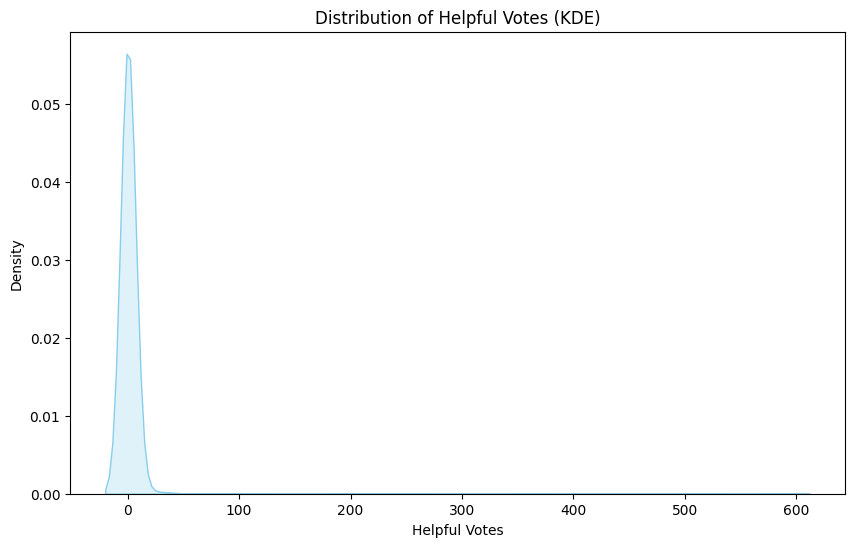

In [29]:
# Seaborn KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['helpful_votes'], fill=True, color="skyblue")
plt.title("Distribution of Helpful Votes (KDE)")
plt.xlabel("Helpful Votes")
plt.ylabel("Density")
plt.show()

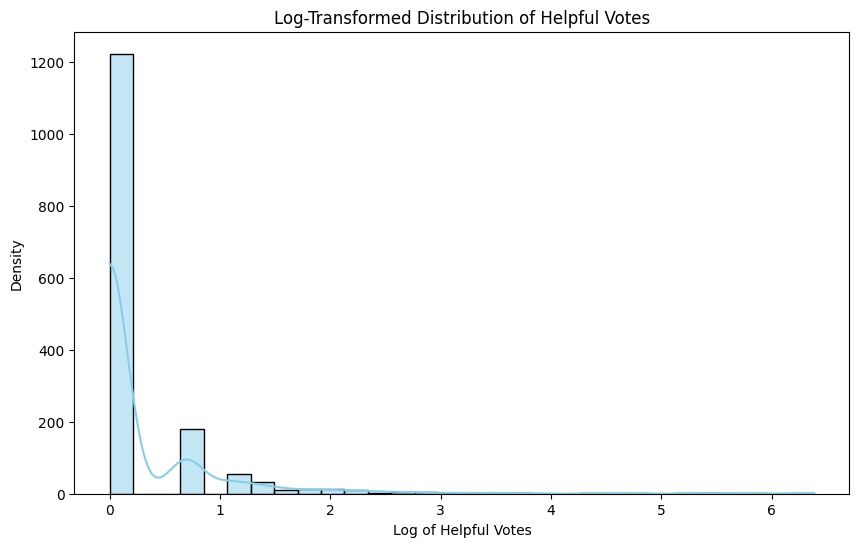

In [74]:
# Apply log transformation to the 'helpful_votes' column to handle skewness
df['log_helpful_votes'] = np.log1p(df['helpful_votes'])

# Plotting the KDE and histogram for log-transformed data
plt.figure(figsize=(10, 6))
sns.histplot(df['log_helpful_votes'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Log-Transformed Distribution of Helpful Votes")
plt.xlabel("Log of Helpful Votes")
plt.ylabel("Density")
plt.show()

In [ ]:
import os
from google.cloud import storage

# Set up Google Cloud Storage client
client = storage.Client()

# Define local and GCS paths
local_model_path_v1 = "/tmp/model_v1.bst"
local_model_path_v2 = "/tmp/model_v2.bst"
gcs_model_path_v1 = "gs://amazon-reviews-project/experiment/model_v1/model.bst"
gcs_model_path_v2 = "gs://amazon-reviews-project/experiment/model_v2/model.bst"

# Save model locally
classifier.save_model(local_model_path_v1)
classifier.save_model(local_model_path_v2)

# Function to upload to Google Cloud Storage
def upload_to_gcs(local_path, gcs_path):
    bucket_name, blob_name = gcs_path[5:].split("/", 1)
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(local_path)
    print(f"Uploaded {local_path} to {gcs_path}")

# Upload models to Google Cloud Storage
upload_to_gcs(local_model_path_v1, gcs_model_path_v1)
upload_to_gcs(local_model_path_v2, gcs_model_path_v2)


In [ ]:
import google.cloud.aiplatform as aip

In [ ]:
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1.7:latest"

In [ ]:
model_v1 = aip.Model.upload(
    display_name="example_",
    artifact_uri="gs://amazon-reviews-project/experiment/model_v1",
    serving_container_image_uri=DEPLOY_IMAGE,
    is_default_version=True,
    version_aliases=["v3"],
    version_description="This is the first version of the model",
)

print(model_v1)

In [ ]:
model_v2 = aip.Model.upload(
    display_name="example_",
    artifact_uri="gs://amazon-reviews-project/experiment/model_v2",
    serving_container_image_uri=DEPLOY_IMAGE,
    parent_model=model_v1.resource_name,
    is_default_version=True,
    version_aliases=["v4"],
    version_description="This is the second version of the model",
)

print(model_v2)

In [ ]:
PROJECT_ID = "airy-box-431604-j9"

In [ ]:
endpoint = aip.Endpoint.create(
    display_name="example_",
    project=PROJECT_ID,
    location="us-central1",
)

print(endpoint)

In [ ]:
DEPLOY_COMPUTE = "n1-standard-4"
print("Train machine type", DEPLOY_COMPUTE)

In [ ]:
versions = model_v2.versioning_registry.list_versions()
for version in versions:
    print(version)

In [ ]:
models = aip.Model.list(filter="display_name=example_")
print("Number of models:", len(models))
print("Version ID:", models[0].version_id)

model = models[0]

In [ ]:
model

In [ ]:
response = endpoint.deploy(
    model=model,
    deployed_model_display_name="example_",
    machine_type=DEPLOY_COMPUTE,
)

print(endpoint)